In [1]:
!nvidia-smi

Mon May 13 03:41:24 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
!pip install -q transformers numpy pandas datasets matplotlib tensorflow feedparser scikit-learn torch accelerate wordcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 32.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [5]:
import os
from datetime import datetime, timedelta

import math
import numpy as np
import pandas as pd

import feedparser

from sklearn.metrics import accuracy_score

from transformers import BertTokenizer, BertForSequenceClassification, BertConfig
from transformers import pipeline, Trainer, TrainingArguments

from tensorflow.keras.callbacks import CSVLogger, ReduceLROnPlateau, ModelCheckpoint, TensorBoard, EarlyStopping, LearningRateScheduler

from datasets import Dataset

import matplotlib.pyplot as plt
from wordcloud import WordCloud


Scrape Yahoo Finacne News

In [ ]:
class YahooFinanceNews:
    def __init__(self):
        self.rss = 'https://feeds.finance.yahoo.com/rss/2.0/headline?s=%s&region=US&lang=en-US'

    def fetch_news(self, ticker, days=7):

        # Parse the RSS feed
        feed = feedparser.parse(self.rss % ticker)

        # Get the current date
        current_date = datetime.now()

        # Filter the entries based on the days
        recent_entries = [entry for entry in feed.entries if (current_date - datetime(*entry.published_parsed[:6])) <= timedelta(days=days)]

        return recent_entries

Financial Bert Training

In [6]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    return {'accuracy':  accuracy_score(predictions, labels)}


def trainer_finbert(model, tokenizer, train_datasets, val_datasets, epochs, save_path='finbert'):

    args = TrainingArguments(
        output_dir = 'temp/',
        evaluation_strategy = 'epoch',
        save_strategy = 'epoch',
        learning_rate=2e-5,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=32,
        num_train_epochs=epochs,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model='accuracy')


    trainer = Trainer(
        model = model,
        args = args,
        train_dataset= train_datasets,
        eval_dataset= val_datasets,
        compute_metrics = compute_metrics)



    trainer.train()

    # Capture all metrics dynamically from trainer's log history
    history = {}
    for entry in trainer.state.log_history:
        for key, value in entry.items():
            # Convert naming from 'eval_*' to 'val_*'
            formatted_key = key.replace("eval_", "val_")
            if formatted_key not in history:
                history[formatted_key] = []
            history[formatted_key].append(value)

    plot_metrics(history, model_name='finbert')

    save_model(trainer, tokenizer, path=save_path)
    return trainer

def save_model(trainer, tokenizer, path):
    trainer.save_model(path)
    tokenizer.save_pretrained(path)


def plot_metrics(history, model_name):
    save_path = 'training_history/'
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    # Adapt for Keras' History object
    if not isinstance(history, dict):
        history_data = history.history
    else:
        history_data = history

    loss = history_data.get('loss', [])
    val_loss = history_data.get('val_loss', [])
    accuracy = history_data.get('accuracy', [])
    val_accuracy = history_data.get('val_accuracy', [])
    lr = history_data.get('lr', [])

    metrics_to_plot = ['loss', 'accuracy', 'lr']
    metrics_to_plot += [metric for metric in history_data.keys() if metric not in {'loss', 'val_loss', 'accuracy', 'val_accuracy', 'lr'}]

    total_metrics = len(metrics_to_plot)
    num_columns = int(math.sqrt(total_metrics))  # We'll have a roughly square layout
    num_rows = math.ceil(total_metrics / num_columns)

    plt.figure(figsize=(5*num_columns, 4*num_rows))

    for idx, metric in enumerate(metrics_to_plot, start=1):
        plt.subplot(num_rows, num_columns, idx)

        if metric == "loss":
            plt.plot(loss, label='Train Loss')
            plt.plot(val_loss, label='Validation Loss')
            plt.title('Loss Evolution')
        elif metric == "accuracy":
            plt.plot(accuracy, label='Train Accuracy')
            plt.plot(val_accuracy, label='Validation Accuracy')
            plt.title('Accuracy Evolution')
        elif metric == "lr":
            plt.plot(lr, label='Learning Rate')
            plt.title('Learning Rate Evolution')
        else:
            train_metric = history_data[metric]
            val_metric_key = f'val_{metric}'
            val_metric = history_data.get(val_metric_key, [])
            plt.plot(train_metric, label=f'Train {metric}')
            if val_metric:
                plt.plot(val_metric, label=f'Validation {metric}')
            plt.title(f'{metric} Evolution')

        plt.legend()

    plt.tight_layout()
    plt.savefig(os.path.join(save_path, f'{model_name}_training_metrics.png'))
    plt.show()

In [10]:
def create_finbert_datasets(parquet_path):
    # Read in Parquet file dataset
    df = pd.read_parquet(parquet_path)

    # Drop NaN
    df = df.dropna()

    # Remap
    # remap = {
    #     0: 2,  # neutral
    #     1: 0,  # positive
    #     2: 1   # negative
    # }

    # Map the labels using remap
    # df['label'] = df['label'].map(remap)

    # Create a Dataset from the DataFrame
    dataset = Dataset.from_pandas(df)

    # Inspect dataset
    print(df.head())


    # Generate Word Cloud
    text = " ".join(review for review in df.text)
    wordcloud = WordCloud(background_color="white").generate(text)

    # Display the generated image:
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

    return dataset

def finbert_dataset_splitting(dataset):
    # Splitting the dataset into training and validation sets
    datasets = dataset.train_test_split(test_size=0.1, seed=42)

    train_dataset = datasets["train"]
    validation_dataset = datasets["test"]

    return train_dataset, validation_dataset


def finbert_datasets_mapping(dataset, tokenizer, debug=True):
    dataset = dataset.map(lambda e: tokenizer(e['text'], truncation=True, padding='max_length', max_length=128), batched=True)
    if debug: print(dataset)

    return dataset


def finbert_dataset_format(dataset,
                   column_names=["input_ids", "token_type_ids", "attention_mask", "label"],
                   format_type="torch",
                   debug=True):
    dataset.set_format(type=format_type, columns=column_names)

    if debug: print(dataset)

    return dataset

In [ ]:
def intialize_bert_model(path='bert-base-uncased', num_labels=3):
    # Intialized_model
    model = BertForSequenceClassification.from_pretrained(path, num_labels=num_labels)

    # 0=negative, 1=positive, 2=neutral
    # Modify label names according to datasets
    model.config.id2label = {
        0: "negative",
        1: "positive",
        2: "neutral"
    }

    model.config.label2id = {
        "negative": 0,
        "positive": 1,
        "neutral": 2
    }

    # Intialized tokenizer
    tokenizer = BertTokenizer.from_pretrained(path)

    return model, tokenizer

In [ ]:
# Initialized Bert Model
finbert_model, finbert_tokenizer = intialize_bert_model(path='bert-base-uncased', num_labels=3)
print(finbert_model.config)
print(finbert_tokenizer)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "negative",
    "1": "positive",
    "2": "neutral"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "negative": 0,
    "neutral": 2,
    "positive": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.40.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

BertTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_t

In [8]:
train_path = 'datasets/train-00000-of-00001-db1b9d43fb2c6ce5.parquet'
test_path = 'datasets/test-00000-of-00001-106b8ac96d1287d8.parquet'

                                                text  label
0  $BYND - JPMorgan reels in expectations on Beyo...      0
1  $CCL $RCL - Nomura points to bookings weakness...      0
2  $CX - Cemex cut at Credit Suisse, J.P. Morgan ...      0
3  $ESS: BTIG Research cuts to Neutral https://t....      0
4  $FNKO - Funko slides after Piper Jaffray PT cu...      0


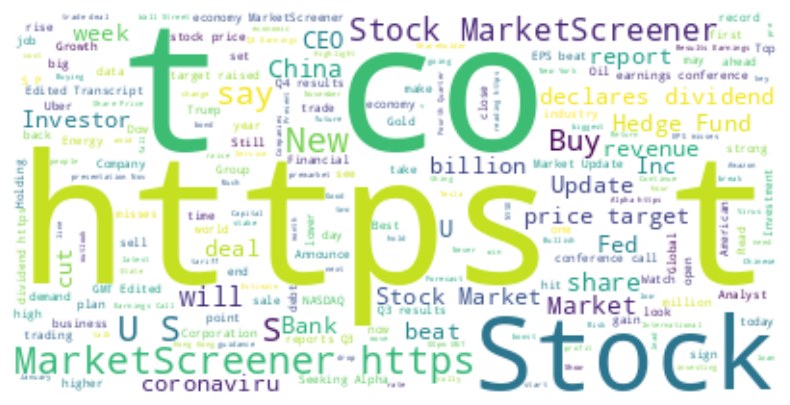

                                                text  label
0  $ALLY - Ally Financial pulls outlook https://t...      0
1  $DELL $HPE - Dell, HPE targets trimmed on comp...      0
2  $PRTY - Moody's turns negative on Party City h...      0
3                   $SAN: Deutsche Bank cuts to Hold      0
4                  $SITC: Compass Point cuts to Sell      0


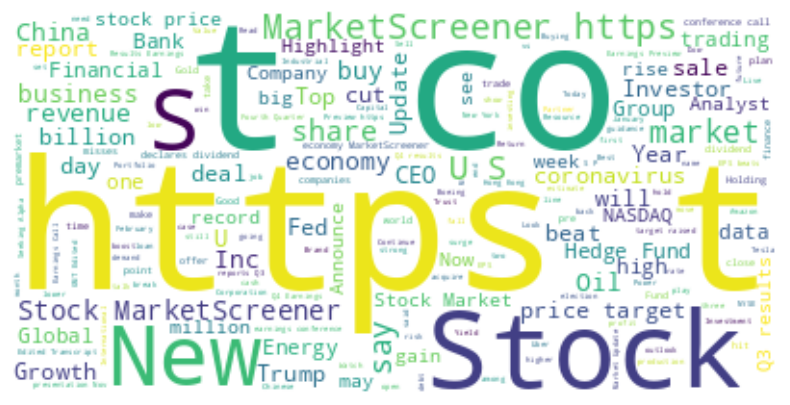

Dataset({
    features: ['text', 'label'],
    num_rows: 9543
})

In [11]:
# Datasets for Training Finbert Model
train_finbert_dataset = create_finbert_datasets(train_path)
test_finbert_dataset = create_finbert_datasets(test_path)
train_finbert_dataset

In [ ]:
# Split train dataset for validation
train_finbert_dataset, val_finbert_dataset = finbert_dataset_splitting(train_finbert_dataset)

In [ ]:
# Mapping
train_finbert_dataset = finbert_datasets_mapping(train_finbert_dataset, finbert_tokenizer)
val_finbert_dataset = finbert_datasets_mapping(val_finbert_dataset, finbert_tokenizer)
test_finbert_dataset = finbert_datasets_mapping(test_finbert_dataset, finbert_tokenizer)

Map:   0%|          | 0/8588 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 8588
})


Map:   0%|          | 0/955 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 955
})


Map:   0%|          | 0/2388 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 2388
})


In [ ]:
# Correct Format
train_finbert_dataset = finbert_dataset_format(train_finbert_dataset, debug=True)
val_finbert_dataset = finbert_dataset_format(val_finbert_dataset, debug=True)
test_finbert_dataset = finbert_dataset_format(test_finbert_dataset, debug=True)

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 8588
})
Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 955
})
Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 2388
})


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.415089,0.848168
2,0.487000,0.343856,0.873298
3,0.487000,0.366698,0.862827
4,0.170500,0.449411,0.869110
5,0.170500,0.530635,0.864921
6,0.074100,0.577825,0.875393
7,0.074100,0.684387,0.865969
8,0.027300,0.699647,0.872251
9,0.027300,0.713895,0.871204
10,0.015300,0.719202,0.872251


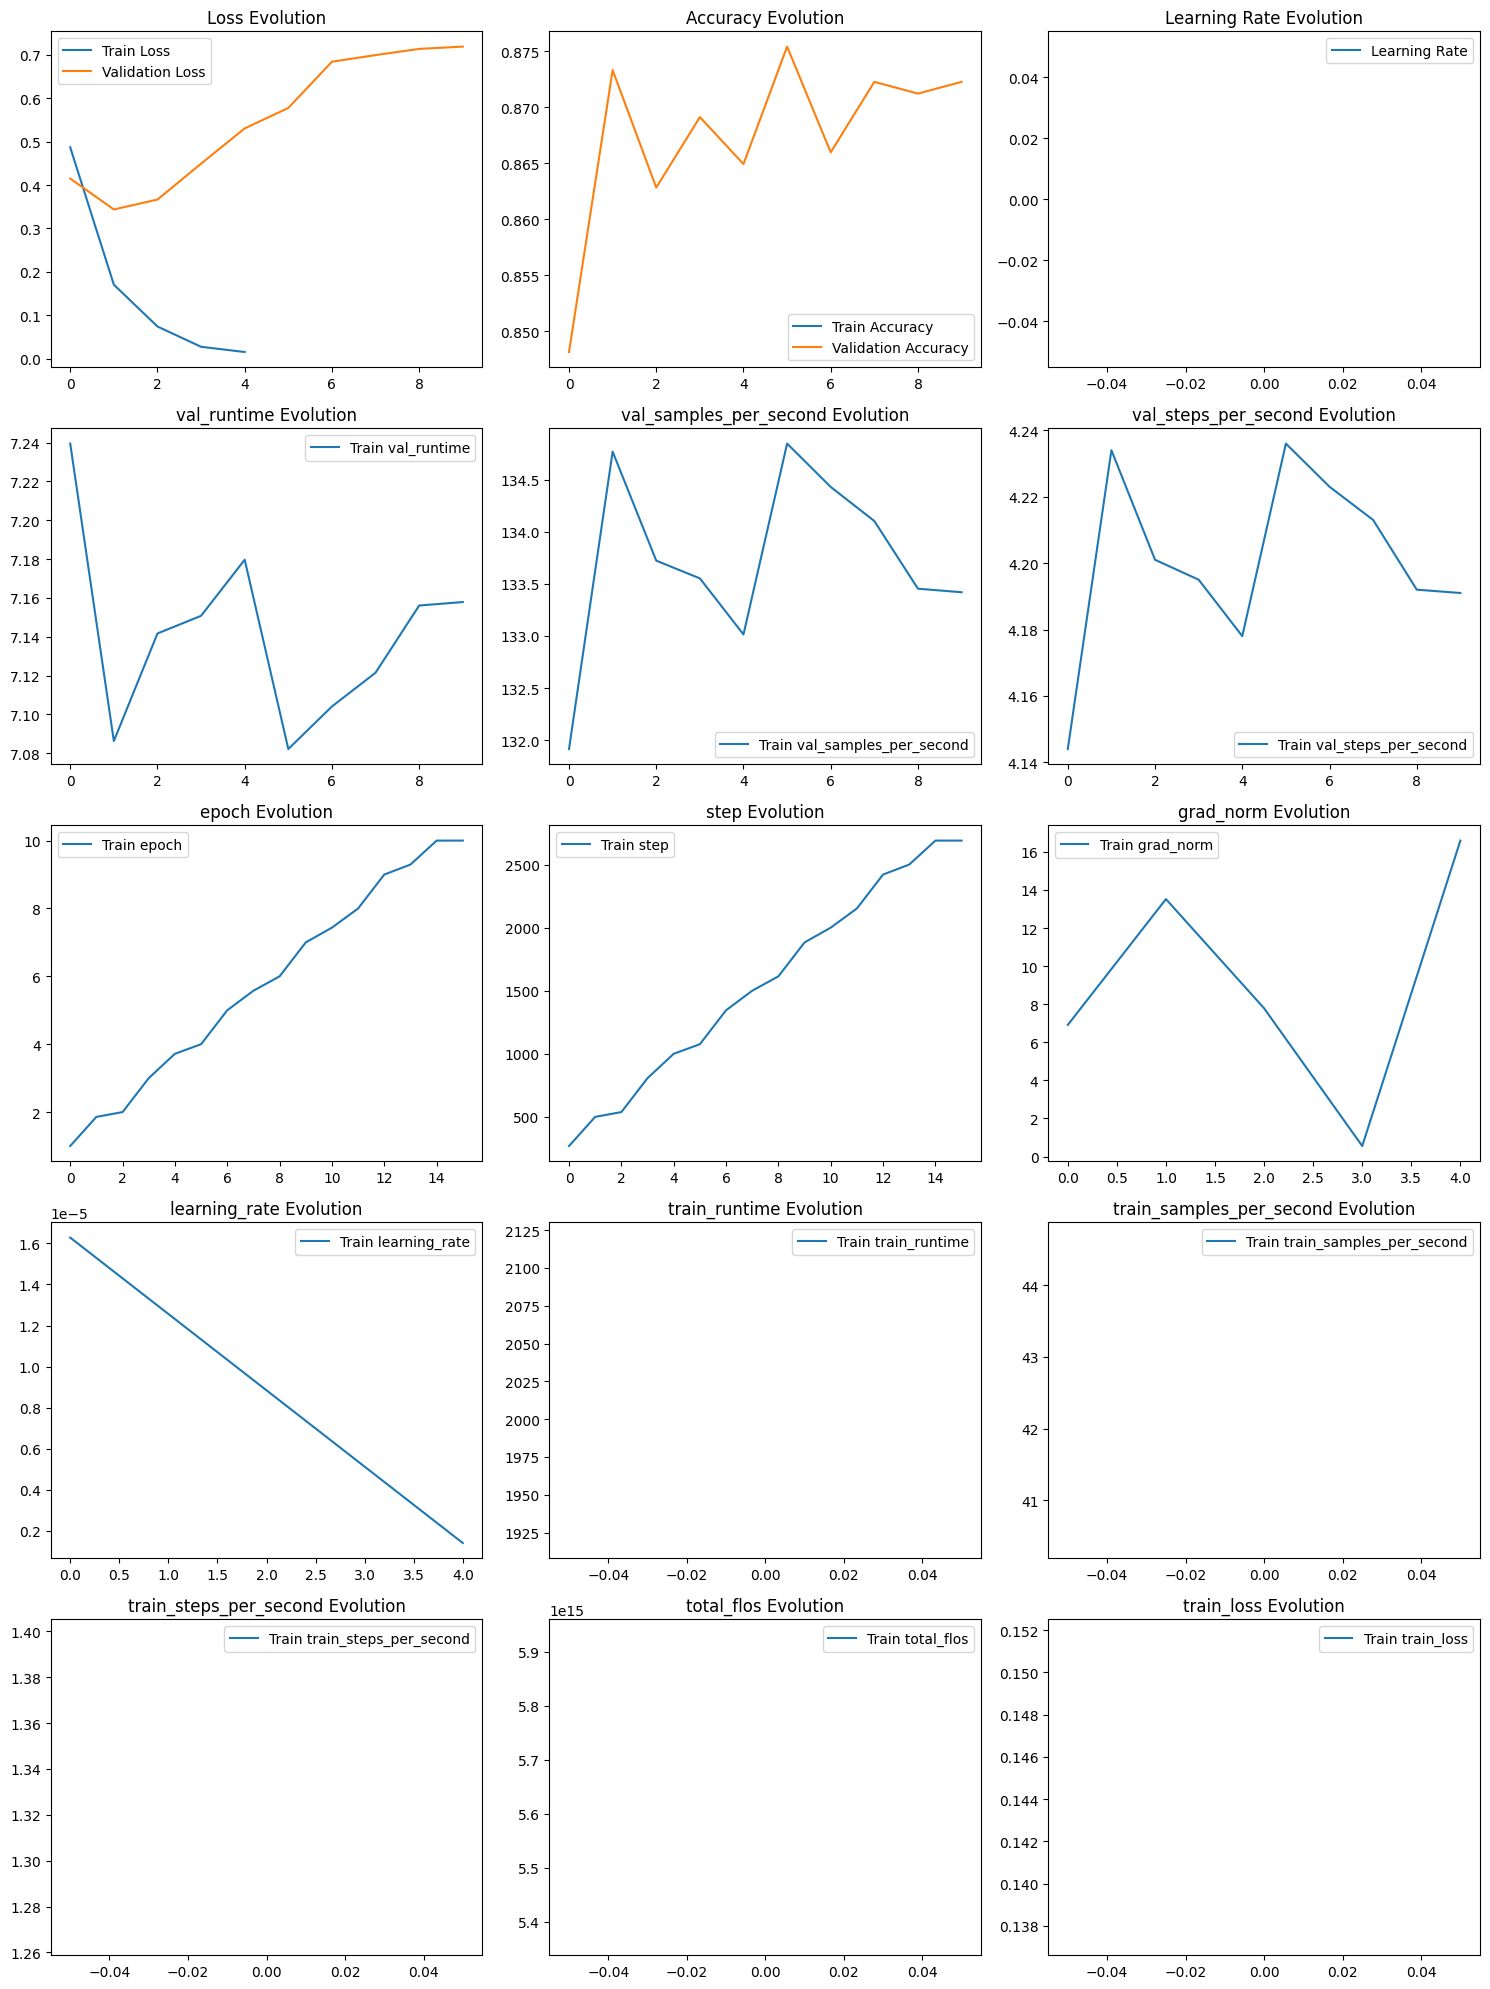

In [ ]:
# Training Finbert  Model
trainer = trainer_finbert(finbert_model, finbert_tokenizer, train_finbert_dataset, val_finbert_dataset, epochs=10)

In [ ]:
# Test on Test Dataset
finbert_model.eval()
trainer.predict(test_finbert_dataset).metrics

{'test_loss': 0.5978606939315796,
 'test_accuracy': 0.878140703517588,
 'test_runtime': 17.92,
 'test_samples_per_second': 133.259,
 'test_steps_per_second': 4.185}

In [ ]:
finbert_model, finbert_tokenizer = intialize_bert_model(path='finbert/', num_labels=3)
nlp = pipeline("text-classification", model=finbert_model, tokenizer=finbert_tokenizer)
results = nlp(['Tesla shares drop by 10%',
              'Tesla miss earning report',
              'Elon Musk fired half of his employee',
              'Elon Musk selling half of Tesla shares'])
# Finbert analysing
for result in results:
    print(result)

{'label': 'negative', 'score': 0.9987013339996338}
{'label': 'negative', 'score': 0.9953173398971558}
{'label': 'neutral', 'score': 0.9032561182975769}
{'label': 'negative', 'score': 0.5217156410217285}


Finbert on Real Life Applications

In [ ]:
def get_sentitment(results):
    neutral_score, positive_score, negative_score = 0.0, 0.0, 0.0

    for result in results:
        sentiment = result['label']
        score = result['score']

        if sentiment == 'neutral':
            neutral_score += score
        elif sentiment == 'positive':
            positive_score += score
        elif sentiment == 'negative':
            negative_score += score

    # Check which sentiment has the highest cumulative score
    if neutral_score > positive_score and neutral_score > negative_score:
        overall_sentiment = 'neutral'
    elif positive_score > neutral_score and positive_score > negative_score:
        overall_sentiment = 'positive'
    else:
        overall_sentiment = 'negative'

    print(f"Overall Sentiment: {overall_sentiment}")

    # Investment decision based on sentiment (example logic)
    if overall_sentiment == 'positive':
        text = "Consider buying."
    elif overall_sentiment == 'negative':
        text = "Consider selling or holding."
    else:
        text = "Stay neutral, await further signals."

    return text

In [ ]:
finbert_model, finbert_tokenizer = intialize_bert_model(path='finbert/', num_labels=3) # Bert Model
finbert_nlp = pipeline("text-classification", model=finbert_model, tokenizer=finbert_tokenizer)
ticker = 'TSLA'
days = 5

# Get news
news = YahooFinanceNews()
news_summary = news.fetch_news(ticker=ticker, days=days)
text = []
# Printing titles
for idx, summary in enumerate(news_summary):
    print(f'{idx}. {summary.summary}')
    text.append(summary.summary)

0. China may be outspending the US when it comes to industrial policy in sectors like electric vehicles and semiconductors, but America is winning on innovation where it can’t on price, according to one China expert.
1. Tesla has had a disappointing 2024 so far, but this latest round of news may turn it around.
2. And it's not because of the technology.
3. Tesla  is offering another classic incentive to move metal.  Tesla is offering 0.99% annual percentage rate on qualifying new Model Y purchases, according to its website.  With $4,250 down on a base model, Tesla’s example down payment, the lower rate saves a buyer about $100 a month.
4. In this article, we will look at the 15 jobs that will be in demand in 2030. We have also talked about the role of AI in hiring and jobs in general. If you want to skip our detailed analysis, head straight to the 5 Jobs That Will Be in Demand in 2030. In April […]
5. Maybe a 5% CD isn't the best choice for your hard-earned money.
6. The bulls are hopi

In [ ]:
# Finbert analysing
results = finbert_nlp(text)
for idx, result in enumerate(results):
    print(f'{idx}. {result}')

sentiment = get_sentitment(results)

0. {'label': 'neutral', 'score': 0.8804231882095337}
1. {'label': 'positive', 'score': 0.5864840745925903}
2. {'label': 'neutral', 'score': 0.9974619150161743}
3. {'label': 'neutral', 'score': 0.9990960359573364}
4. {'label': 'neutral', 'score': 0.9996110796928406}
5. {'label': 'neutral', 'score': 0.9991010427474976}
6. {'label': 'positive', 'score': 0.6389226317405701}
7. {'label': 'negative', 'score': 0.8203148245811462}
8. {'label': 'positive', 'score': 0.7302483320236206}
9. {'label': 'neutral', 'score': 0.9987462759017944}
10. {'label': 'positive', 'score': 0.9982960820198059}
11. {'label': 'neutral', 'score': 0.9991970658302307}
12. {'label': 'neutral', 'score': 0.7396577000617981}
13. {'label': 'positive', 'score': 0.9601696729660034}
14. {'label': 'neutral', 'score': 0.9961250424385071}
15. {'label': 'neutral', 'score': 0.9974451065063477}
16. {'label': 'neutral', 'score': 0.9754822850227356}
17. {'label': 'neutral', 'score': 0.9965718984603882}
18. {'label': 'neutral', 'score'